# Dependencies

In [6]:
import torch
import transformers
from tqdm import tqdm
from datetime import datetime

In [7]:
from torch.utils.data import Dataset, DataLoader

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

### Detect AI Generated Text data (https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data)

In [9]:
df_train_essays = pd.read_csv("./data/train_essays.csv")
print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [10]:
# the amount of generated and written text are really unbalanced
df_train_essays['generated'].value_counts()

# plt.figure(figsize=(6,4))
# df_train_essays['generated'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
# plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
# plt.grid(axis='y', linestyle='--')
# plt.tight_layout()
# plt.show()# # # # # # 

generated
0    1375
1       3
Name: count, dtype: int64

### DAIGT Proper Train Dataset (https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/data)

In [11]:
df_train_essays_ext = pd.read_csv("./data_DAIGT/train_drcat_04.csv")
df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)
df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   44206 non-null  object
 1   text       44206 non-null  object
 2   generated  44206 non-null  int64 
 3   source     44206 non-null  object
 4   prompt     12911 non-null  object
 5   fold       44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [12]:
df_train_essays_ext.head()

,essay_id,text,generated,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


In [70]:
df_train_essays_ext['generated'].value_counts()

# plt.figure(figsize=(6,4))
# df_train_essays_ext['generated'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
# plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
# plt.grid(axis='y', linestyle='--')
# plt.tight_layout()
# plt.show()

generated
0    29792
1    14414
Name: count, dtype: int64

### Combine Data

In [71]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]])
df_train_essays_final.head()

,text,generated
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1


# Model 1 training (distilBERT uncased)

## load first pre-trained model (distilbert-uncased)

In [15]:
# pre-trained model taken from the below link: 
# https://huggingface.co/distilbert/distilbert-base-uncased

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_du1 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_du1.to(device)

cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [28]:
SEQ_LENGTH = 512

from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.20,
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                y_tmp,
                                                test_size=0.50,
                                                random_state=42)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        return text, label

train_data = TextDataset(X_train, y_train)
val_data = TextDataset(X_val, y_val)
test_data = TextDataset(X_test, y_test)

In [18]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    tokens = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(labels)
    return tokens, labels

In [19]:
train_data[0]

("02/23/2011\n\nDear Mrs. Principal,\n\nAs a student maim i think, maybe your idea to make students have an average of B' s only would be a good idea for students to try harder to increase they're grades, but once you think about it twice maim some students have C 's because that is all they can give. Sometimes its not because they didn't study or because they were watching television but because sometimes we get so nervous that rush through the answers or even forget everything we have been studying super hard to succeed. Like I said before I believe not everyone can have an average of B 's but a C is already a passing grade. No one is perfect we all have a couple of mistakes sometimes. Either way if you do all B 's probably the whole school may not participate in any school activity. Now that is the why we shouldn't change it. We should change it though cause it might pressure the students to get higher grades to participate in a sport. The school may also have a higher percent of st

In [20]:
# from torch.optim import AdamW

learning_rate = 1e-5
num_epochs = 5 # change later
batch_size = 64 # change later

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# it is recommended to use AdamW for distilBERT models

# should we include scheduler?




In [21]:
for batch, labels in train_loader:
    print(batch)
    print("Inputs:", batch['input_ids'])
    print("labels:", labels)
    # print('attention mask:', batch['attention_mask'])
    
    break

{'input_ids': tensor([[  101,  1996,  4277,  ...,  2108,  2583,   102],
        [  101,  2031,  2017,  ...,     0,     0,     0],
        [  101,  2839, 12955,  ...,     0,     0,     0],
        ...,
        [  101,  6203,  4054,  ...,     0,     0,     0],
        [  101, 10180, 10888,  ...,     0,     0,     0],
        [  101, 11691,  2003,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Inputs: tensor([[  101,  1996,  4277,  ...,  2108,  2583,   102],
        [  101,  2031,  2017,  ...,     0,     0,     0],
        [  101,  2839, 12955,  ...,     0,     0,     0],
        ...,
        [  101,  6203,  4054,  ...,     0,     0,     0],
        [  101, 10180, 10888,  ...,     0,     0,     0],
        [  101, 11691,  2003,  ...,     0,     0,     0]])
labels: tensor([

Iteration:  10%|█         | 49/478 [00:35<04:51,  1.47it/s]

hi


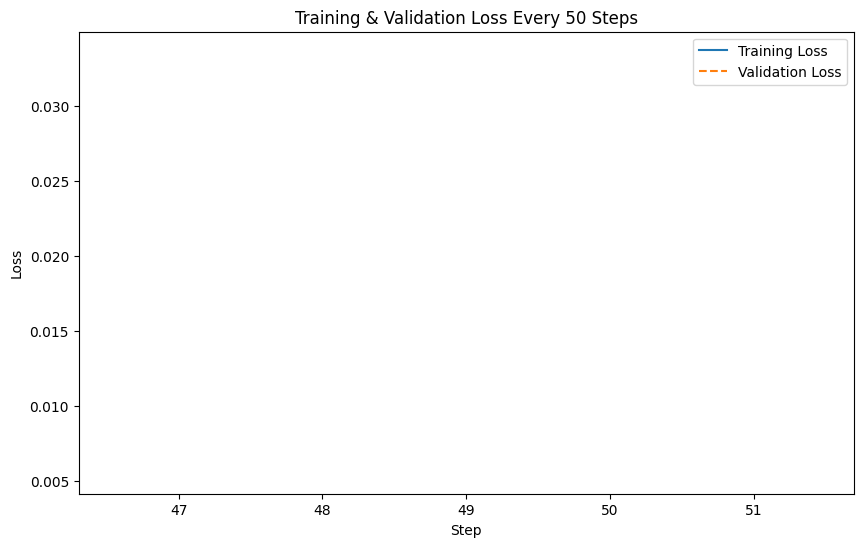

Iteration:  21%|██        | 99/478 [01:15<04:08,  1.52it/s]

hi


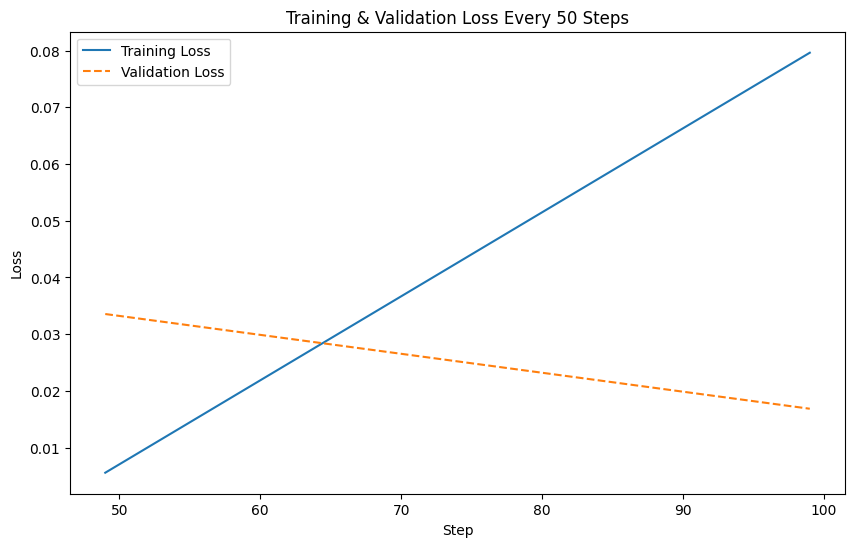

Iteration:  31%|███       | 149/478 [01:56<03:49,  1.43it/s]

hi


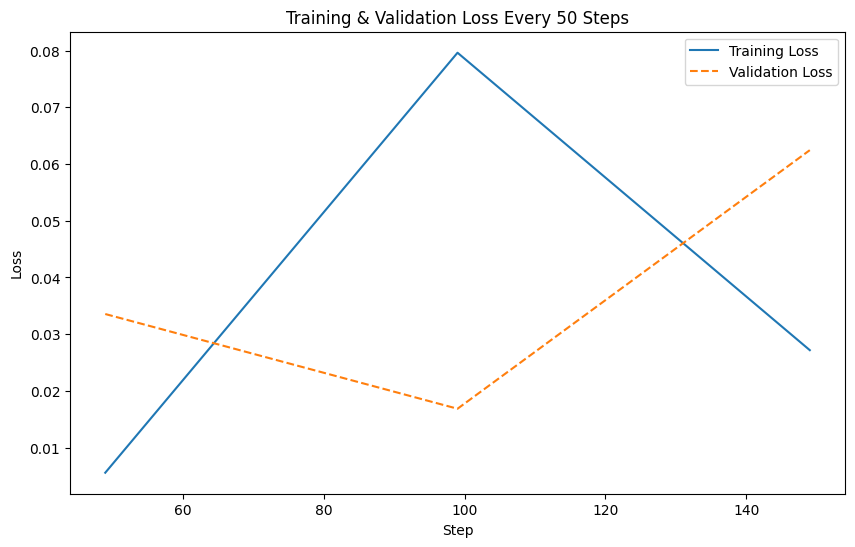

Iteration:  42%|████▏     | 199/478 [02:36<03:04,  1.52it/s]

hi


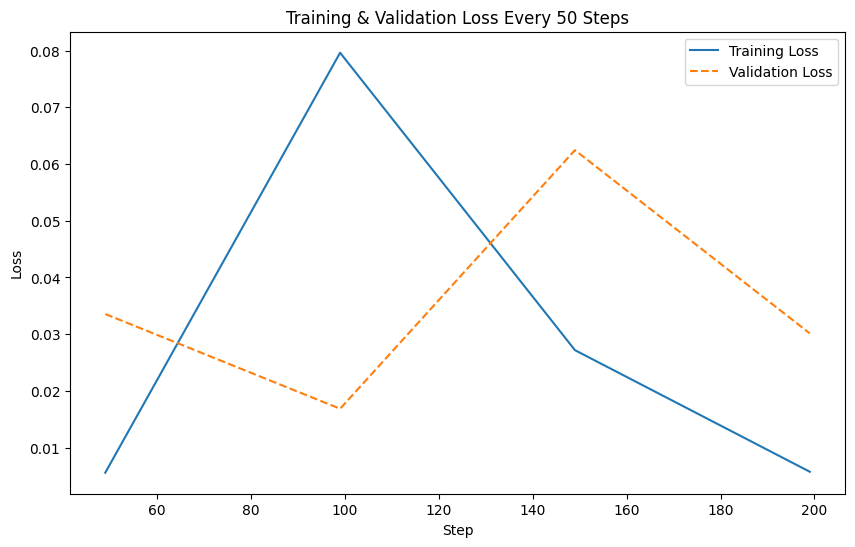

Iteration:  52%|█████▏    | 249/478 [03:17<02:37,  1.45it/s]

hi


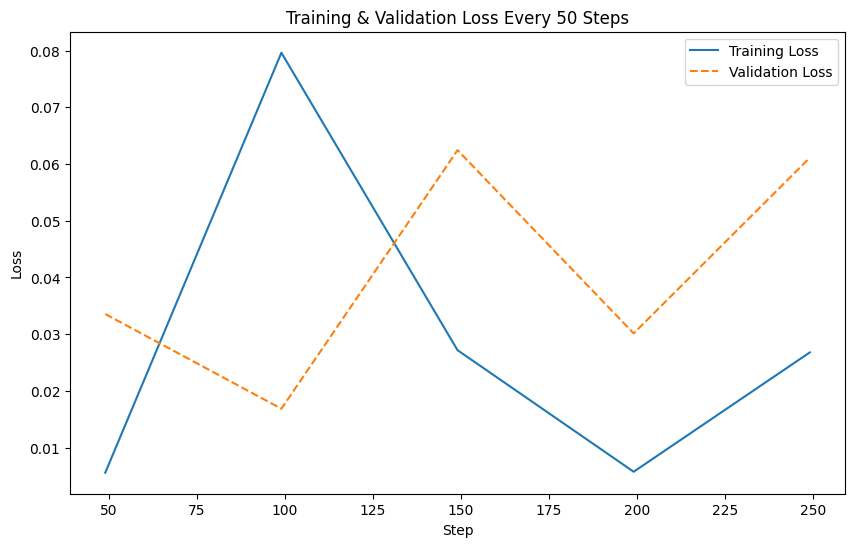

Iteration:  63%|██████▎   | 299/478 [03:58<02:02,  1.46it/s]

hi


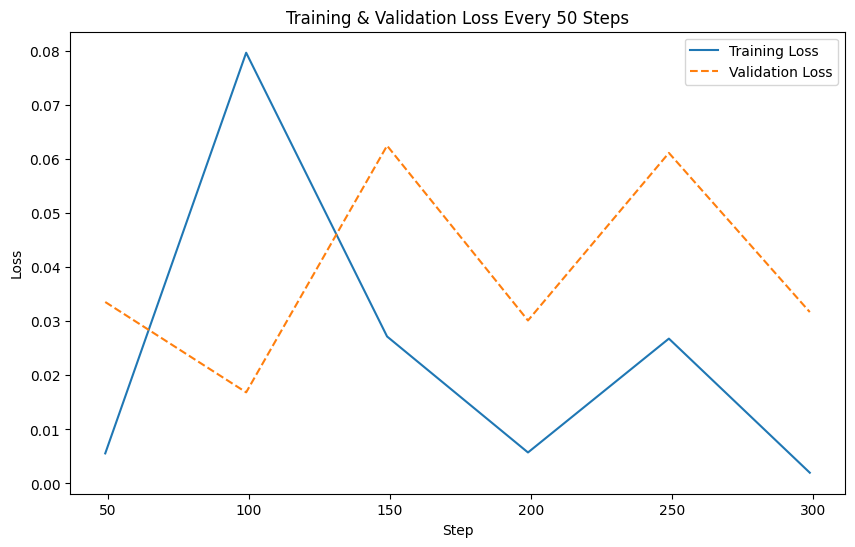

Iteration:  73%|███████▎  | 349/478 [04:39<01:28,  1.46it/s]

hi


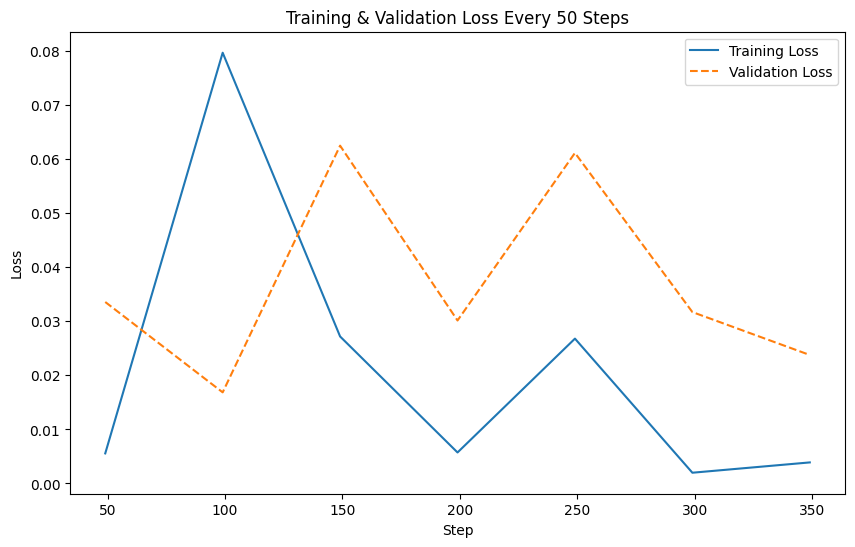

Iteration:  83%|████████▎ | 399/478 [05:20<00:53,  1.46it/s]

hi


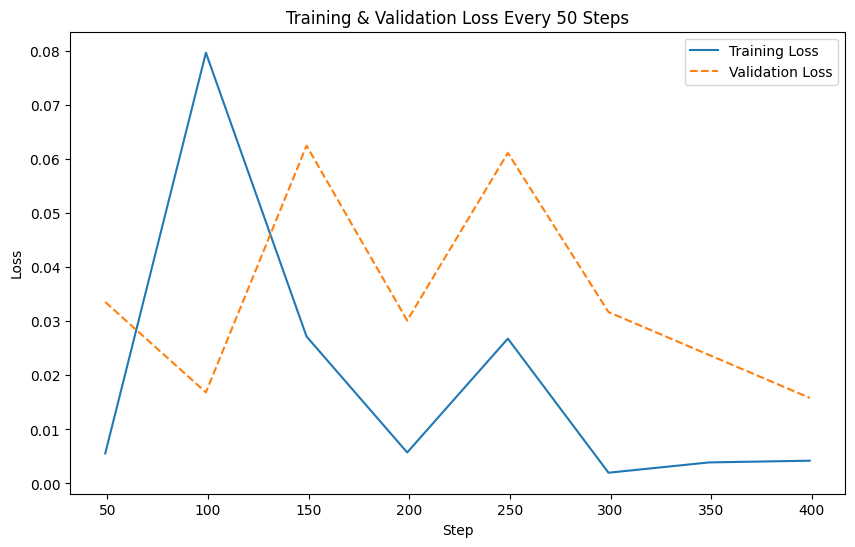

Iteration:  94%|█████████▍| 449/478 [06:04<00:22,  1.29it/s]

hi


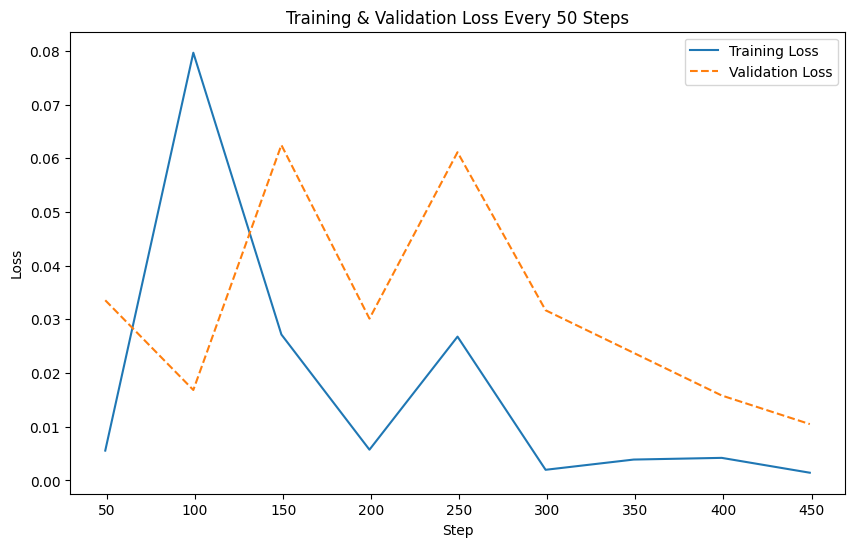

Iteration:  10%|█         | 49/478 [00:33<04:55,  1.45it/s]

hi


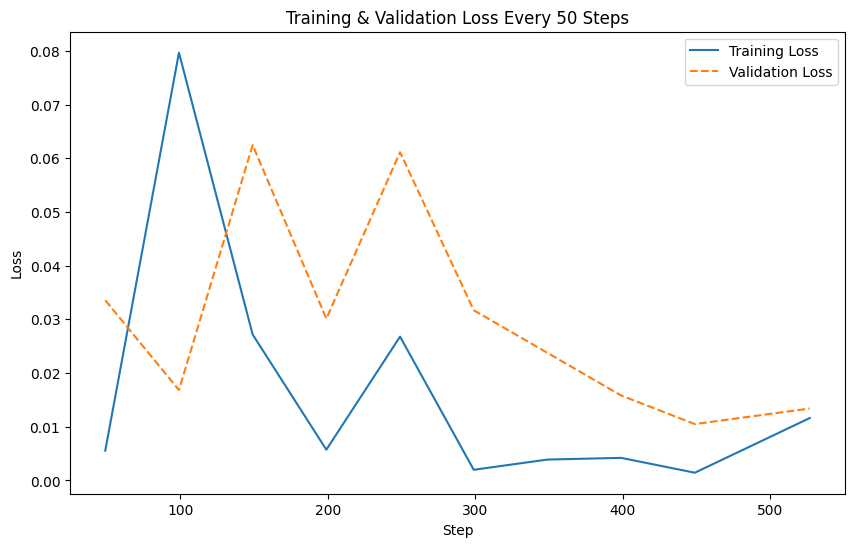

Iteration:  21%|██        | 99/478 [01:14<04:20,  1.46it/s]

hi


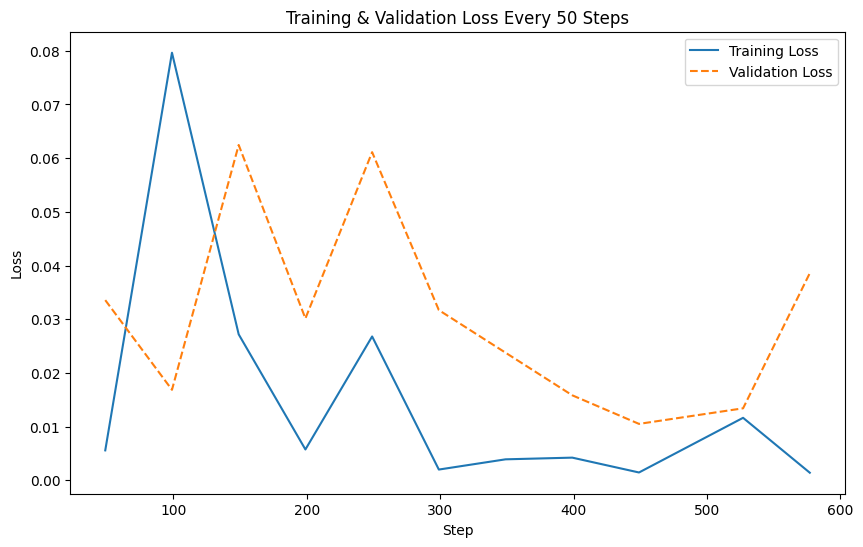

Iteration:  31%|███       | 149/478 [01:55<03:44,  1.46it/s]

hi


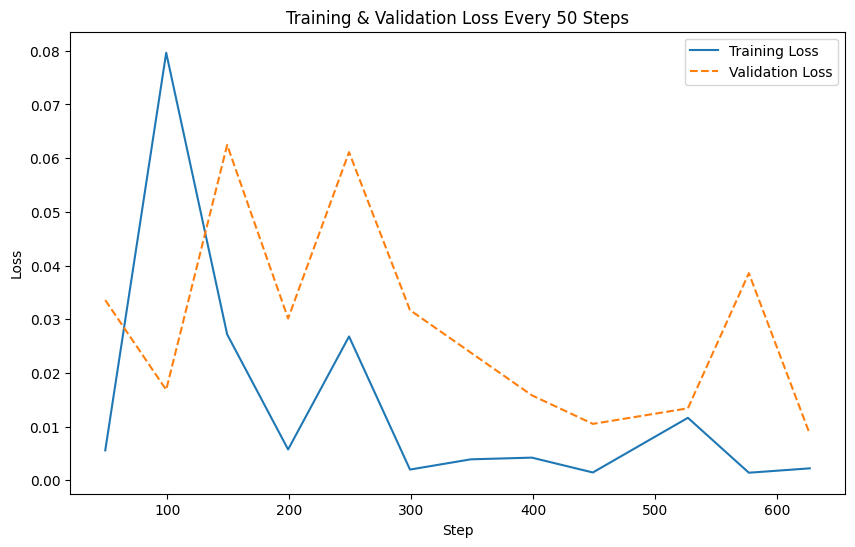

Iteration:  42%|████▏     | 199/478 [02:36<03:25,  1.36it/s]

hi


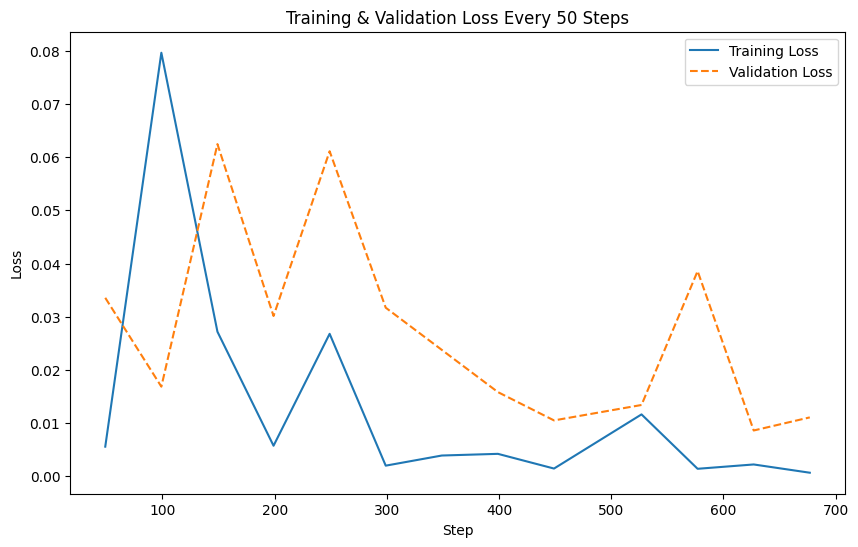

Iteration:  52%|█████▏    | 249/478 [03:17<02:37,  1.45it/s]

hi


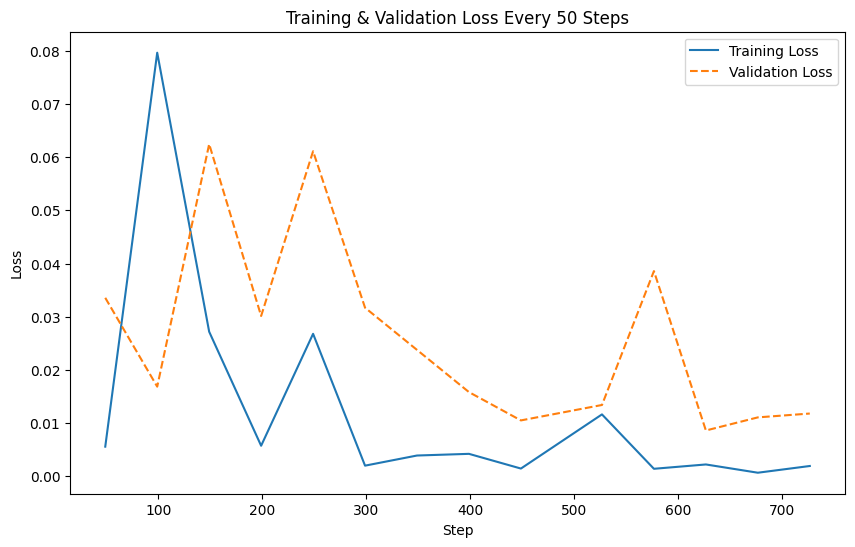

Iteration:  63%|██████▎   | 299/478 [03:58<02:06,  1.41it/s]

hi


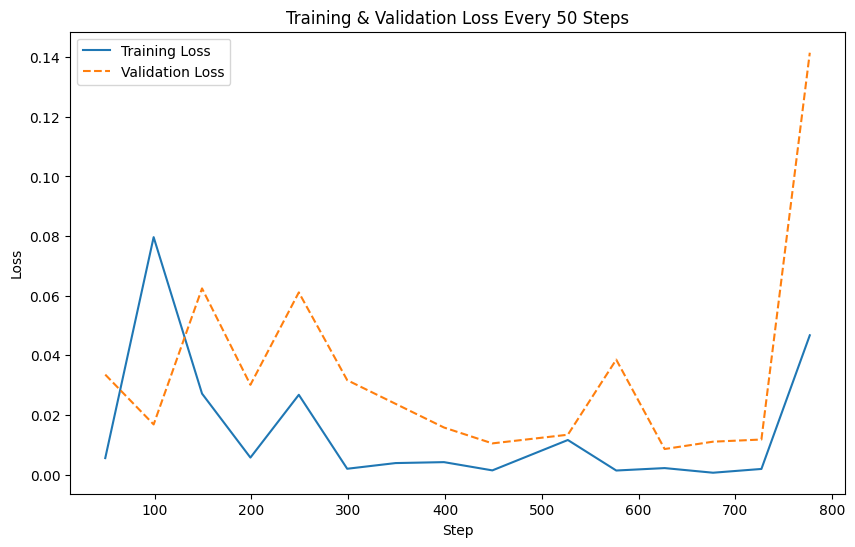

Iteration:  73%|███████▎  | 349/478 [04:38<01:27,  1.48it/s]

hi


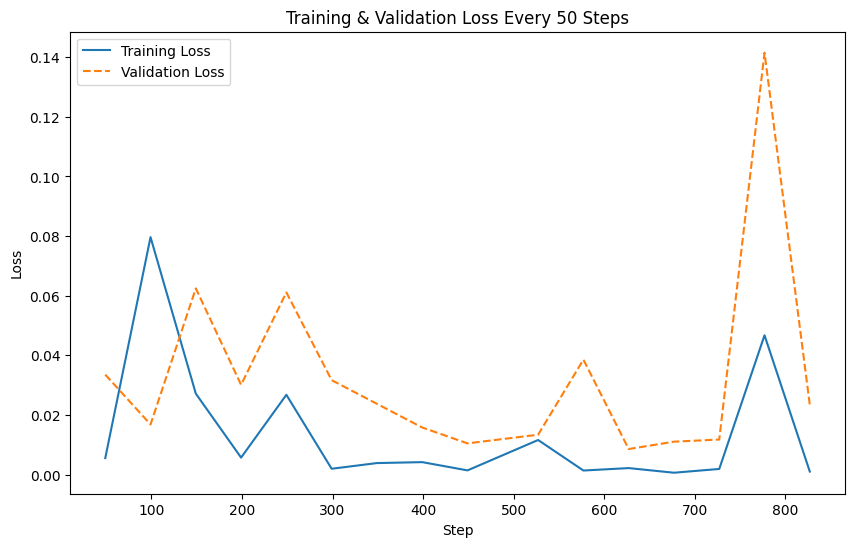

Iteration:  83%|████████▎ | 399/478 [05:19<00:53,  1.47it/s]

hi


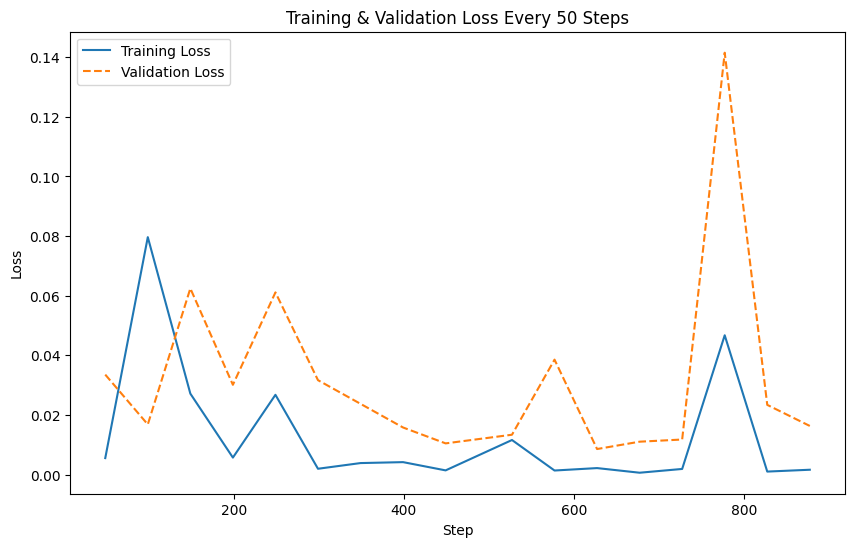

Iteration:  94%|█████████▍| 449/478 [05:59<00:19,  1.47it/s]

hi


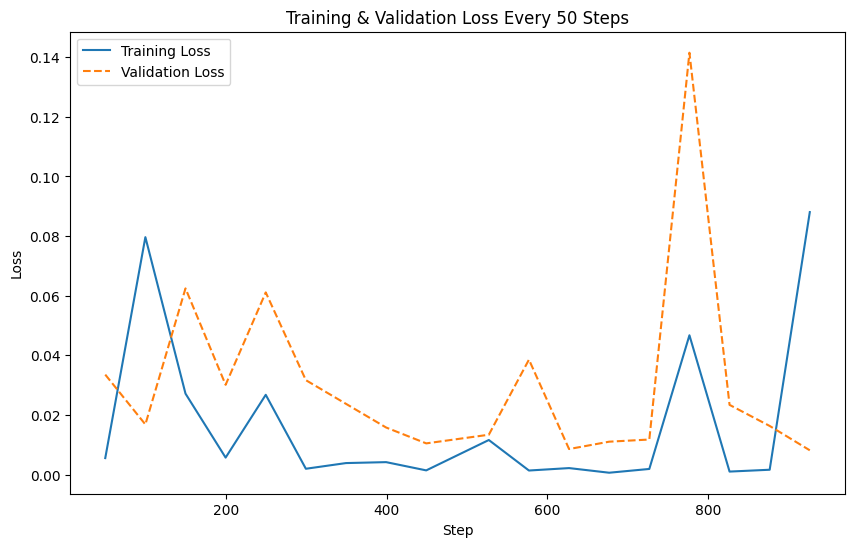

Iteration:  10%|█         | 49/478 [00:33<04:51,  1.47it/s]

hi


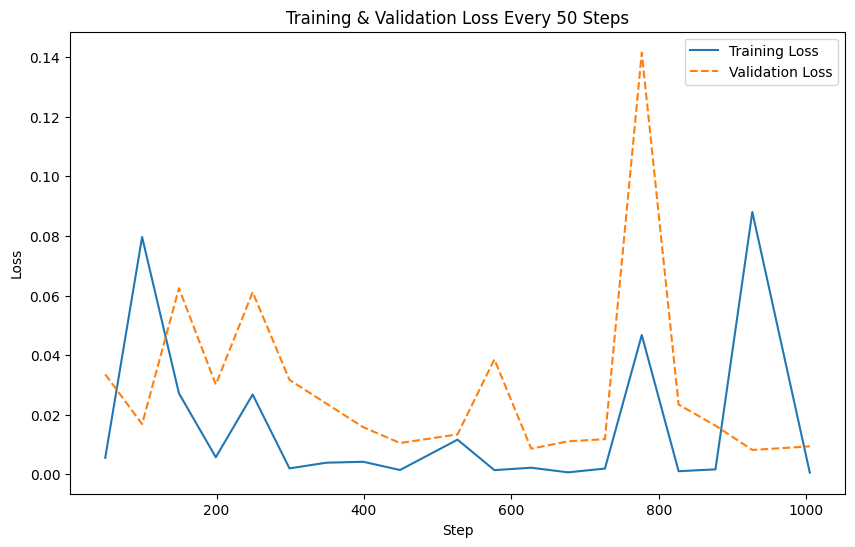

Iteration:  21%|██        | 99/478 [01:13<04:18,  1.47it/s]

hi


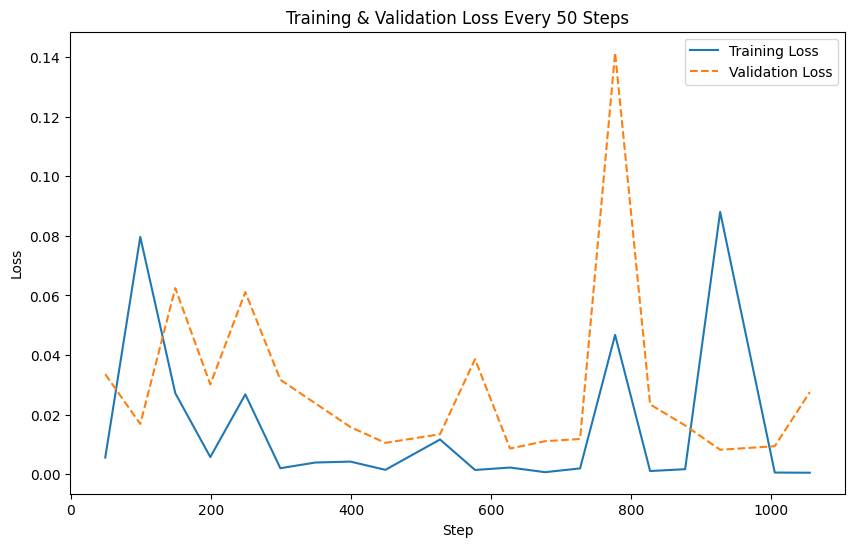

Iteration:  31%|███       | 149/478 [01:53<03:43,  1.47it/s]

hi


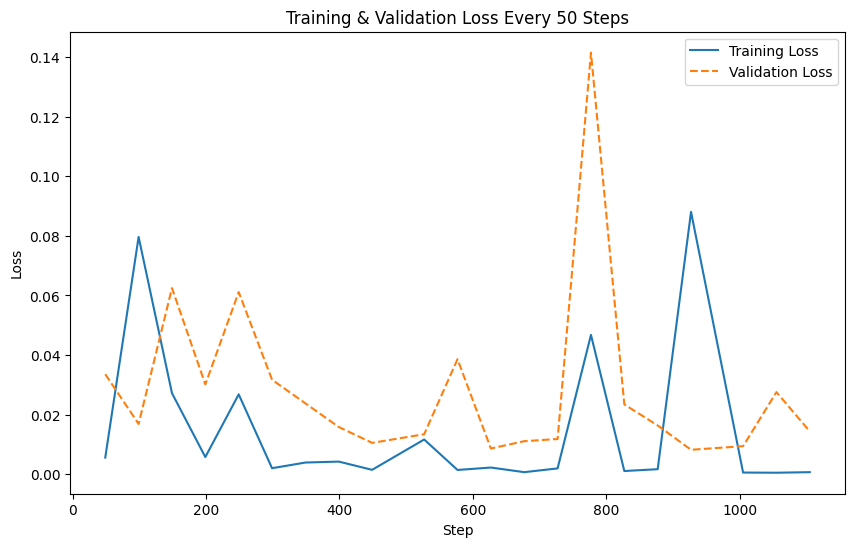

Iteration:  42%|████▏     | 199/478 [02:33<03:09,  1.47it/s]

hi


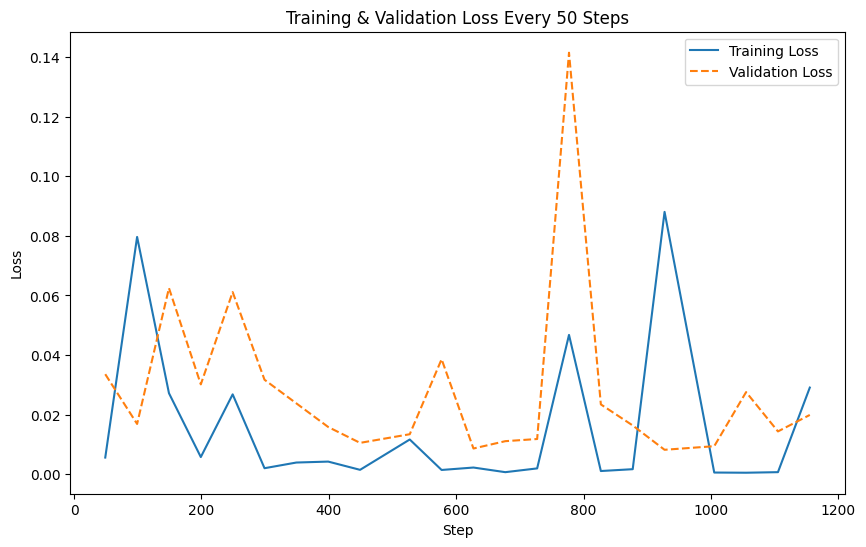

Iteration:  52%|█████▏    | 249/478 [03:13<02:35,  1.47it/s]

hi


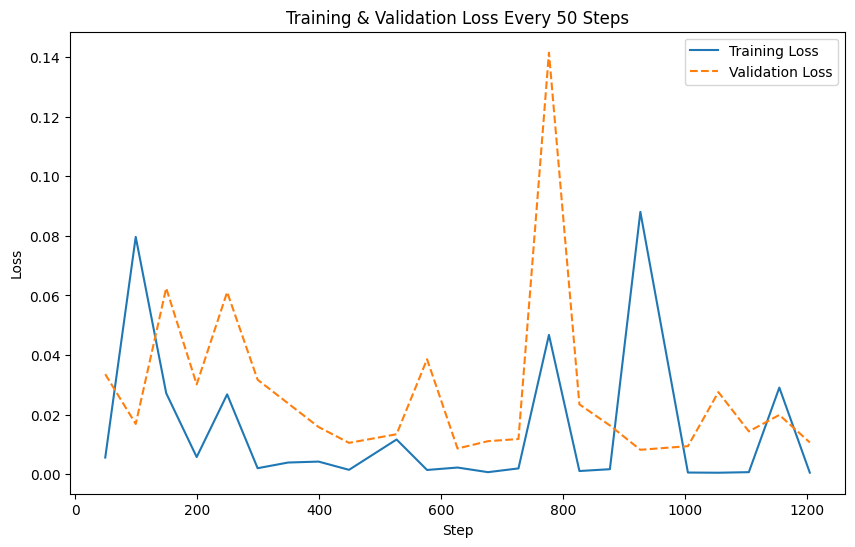

Iteration:  63%|██████▎   | 299/478 [03:54<02:01,  1.48it/s]

hi


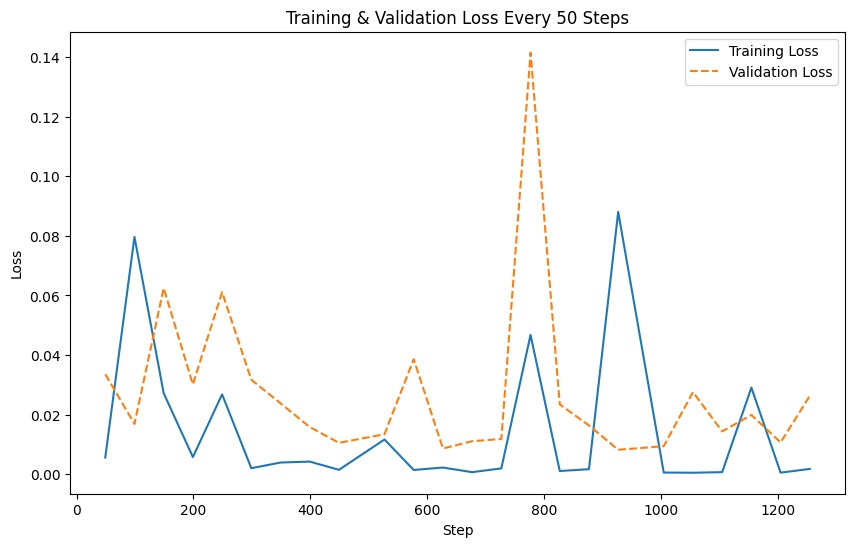

Iteration:  73%|███████▎  | 349/478 [04:34<01:27,  1.48it/s]

hi


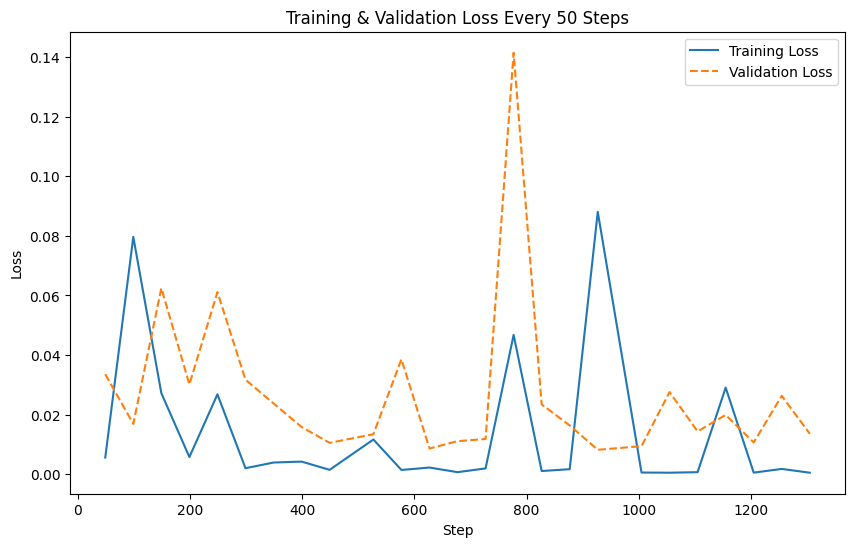

Iteration:  83%|████████▎ | 399/478 [05:14<00:53,  1.49it/s]

hi


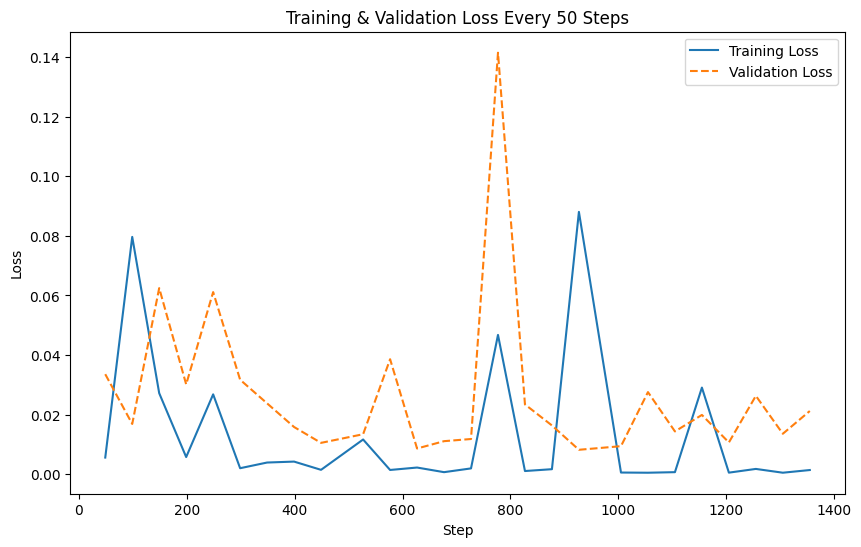

Iteration:  94%|█████████▍| 449/478 [05:54<00:19,  1.47it/s]

hi


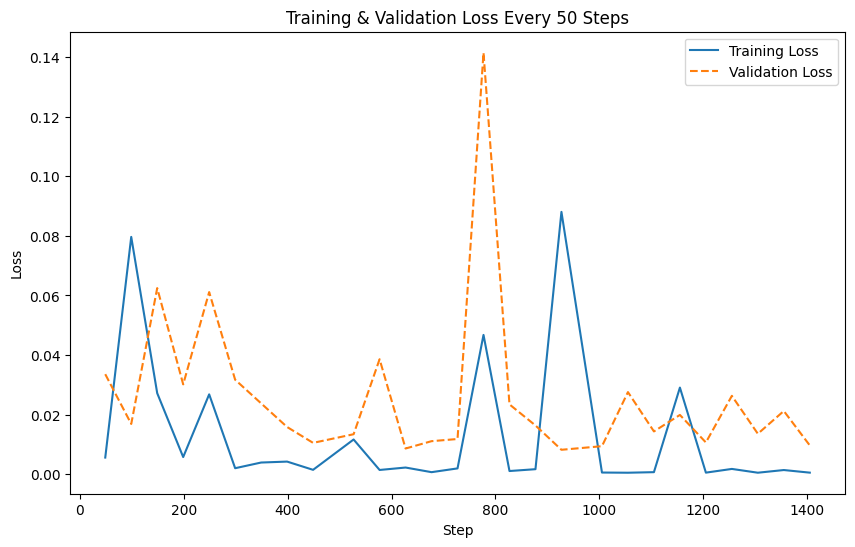

Iteration:  10%|█         | 49/478 [00:32<04:53,  1.46it/s]

hi


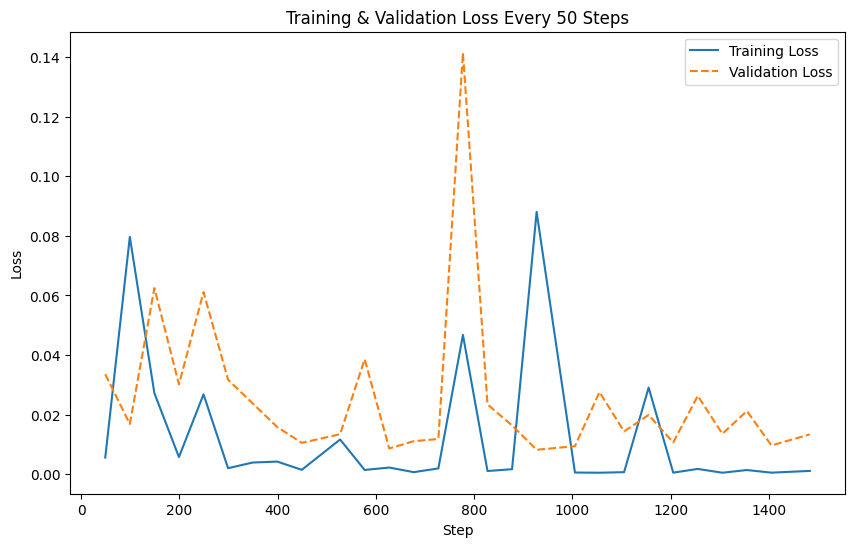

Iteration:  21%|██        | 99/478 [01:13<04:18,  1.47it/s]

hi


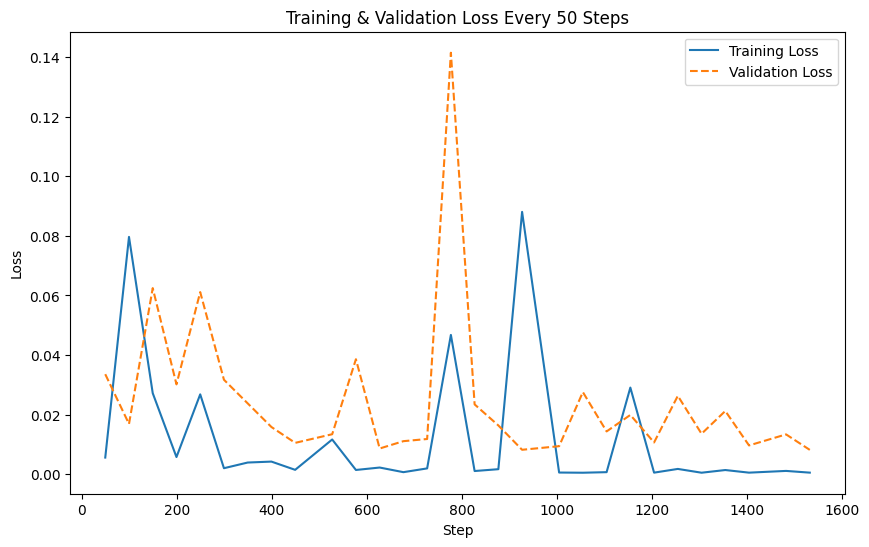

Iteration:  31%|███       | 149/478 [01:53<03:42,  1.48it/s]

hi


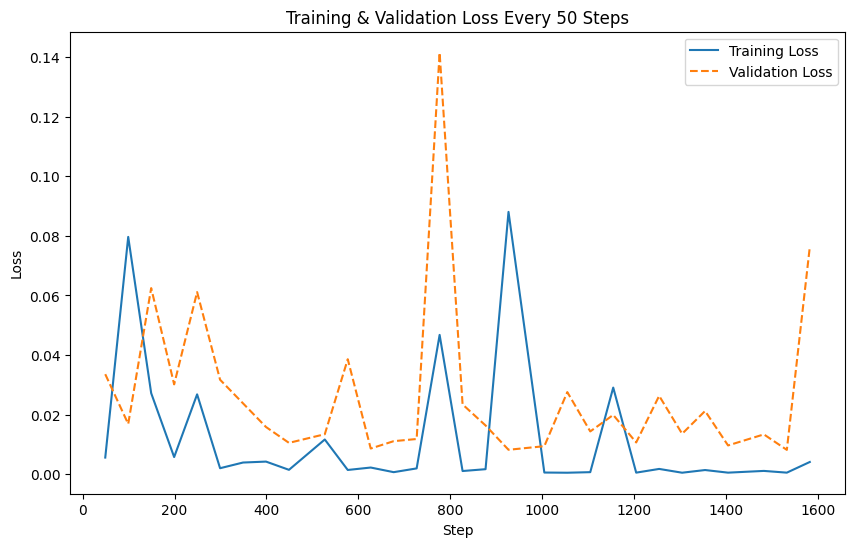

Iteration:  42%|████▏     | 199/478 [02:33<03:08,  1.48it/s]

hi


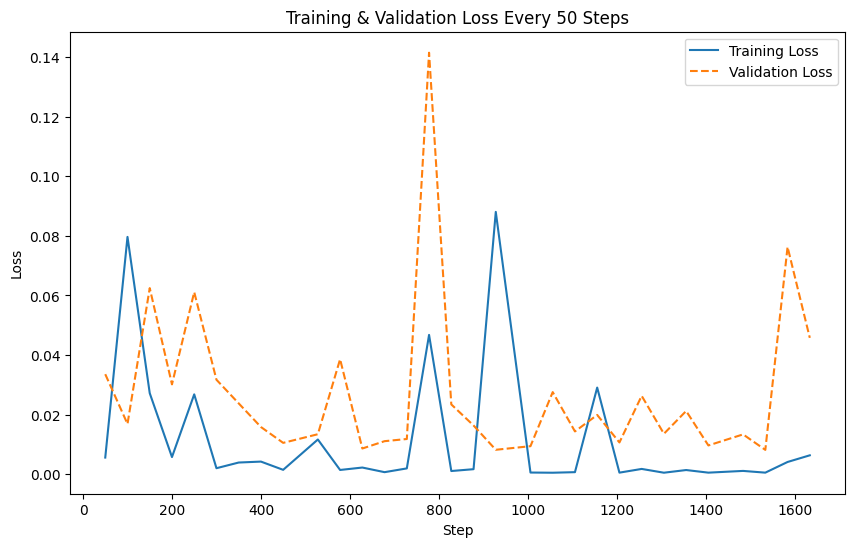

Iteration:  52%|█████▏    | 249/478 [03:13<02:35,  1.48it/s]

hi


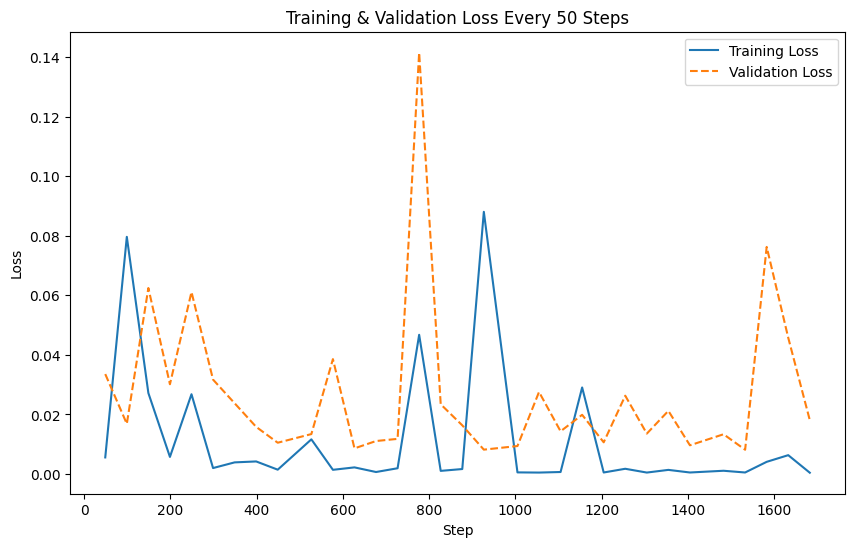

Iteration:  63%|██████▎   | 299/478 [03:53<02:00,  1.49it/s]

hi


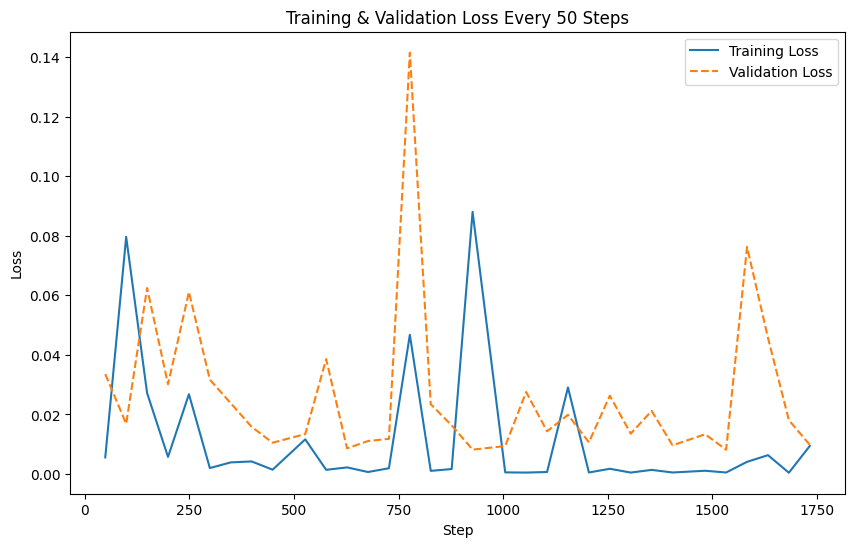

Iteration:  73%|███████▎  | 349/478 [04:33<01:27,  1.48it/s]

hi


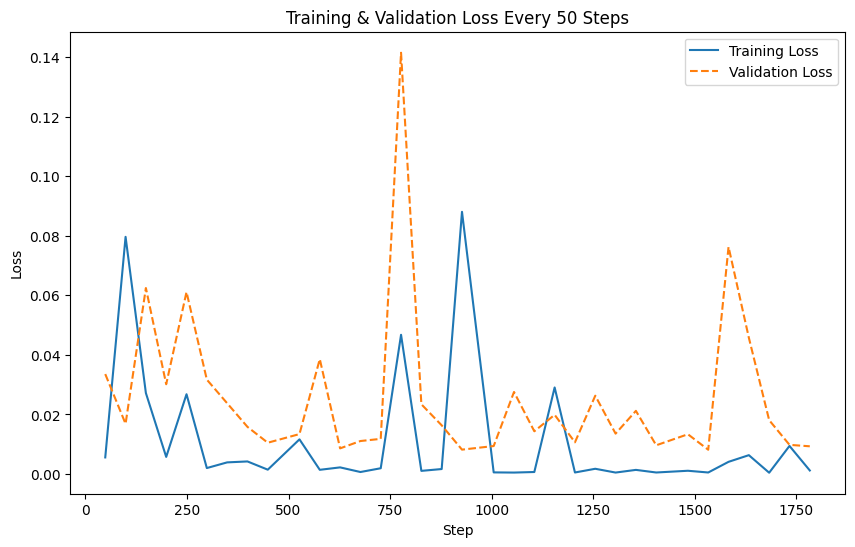

Iteration:  83%|████████▎ | 399/478 [05:14<00:52,  1.51it/s]

hi


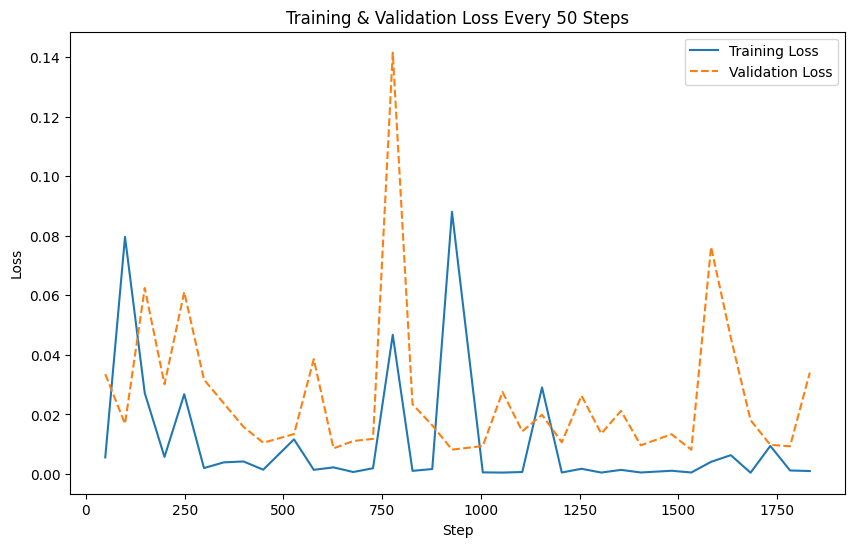

Iteration:  94%|█████████▍| 449/478 [05:56<00:22,  1.31it/s]

hi


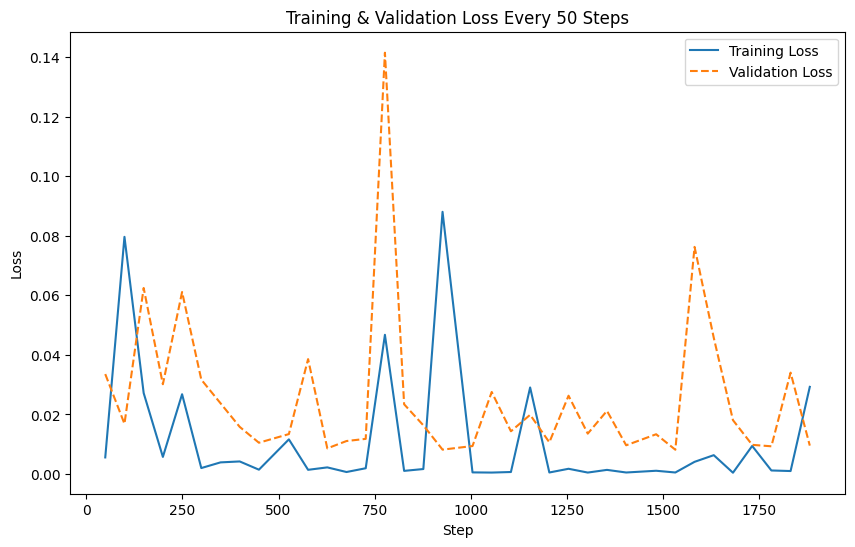

Iteration:  10%|█         | 49/478 [00:34<05:01,  1.42it/s]

hi


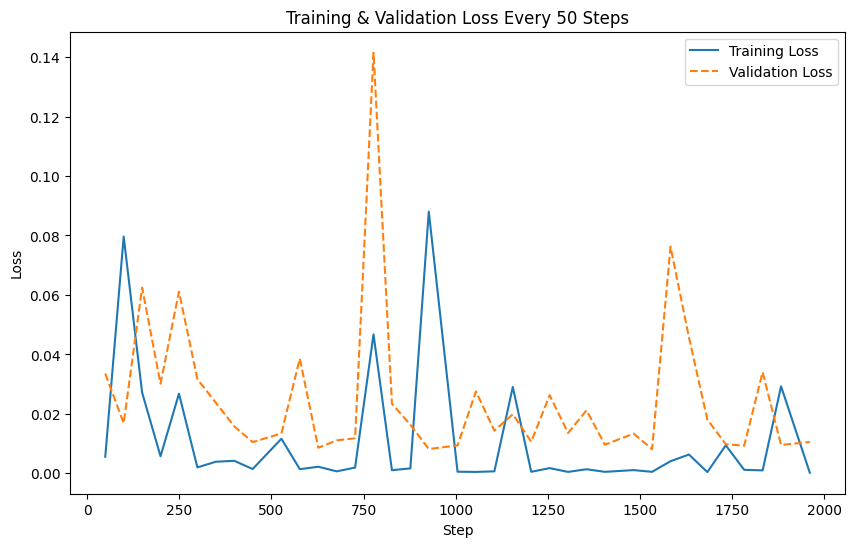

Iteration:  21%|██        | 99/478 [01:15<04:22,  1.44it/s]

hi


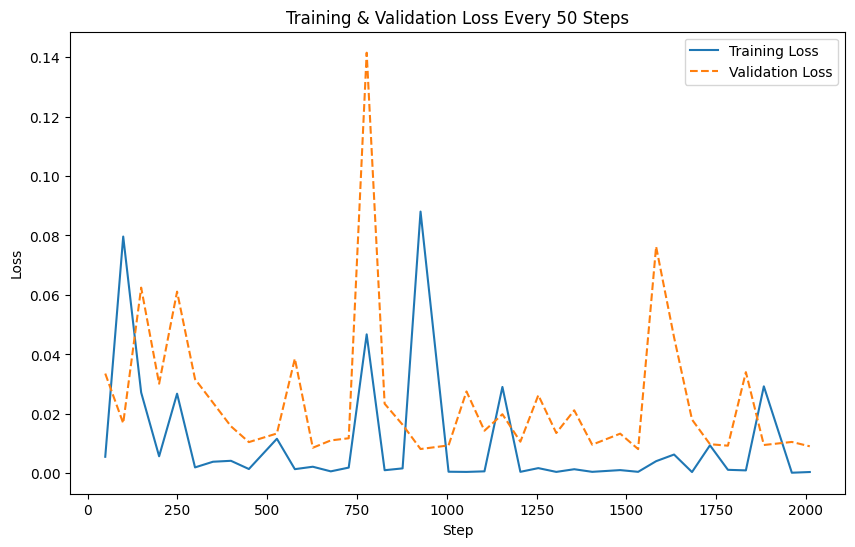

Iteration:  31%|███       | 149/478 [01:58<03:44,  1.47it/s]

hi


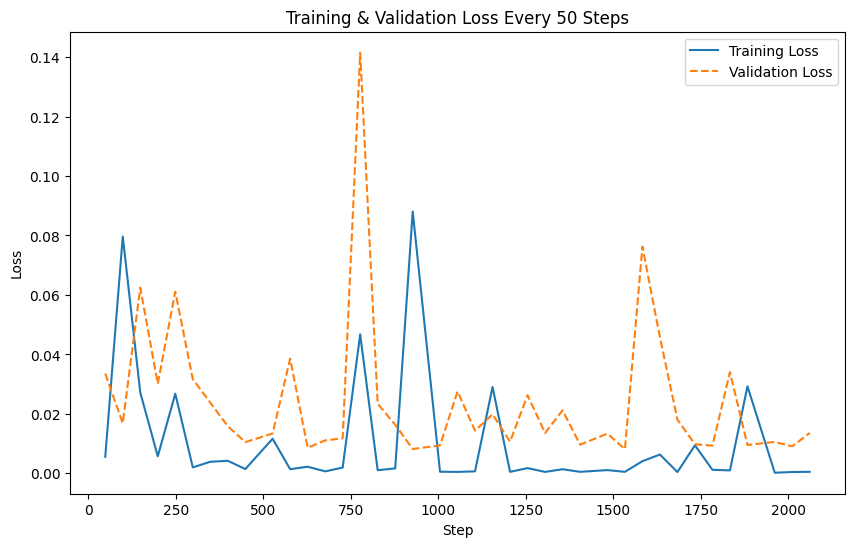

Iteration:  42%|████▏     | 199/478 [02:39<03:13,  1.44it/s]

hi


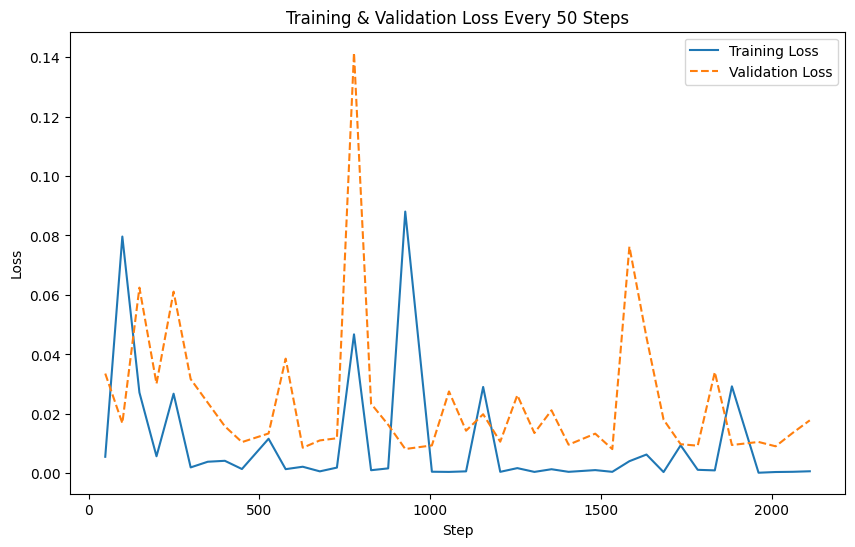

Iteration:  52%|█████▏    | 249/478 [03:22<02:42,  1.41it/s]

hi


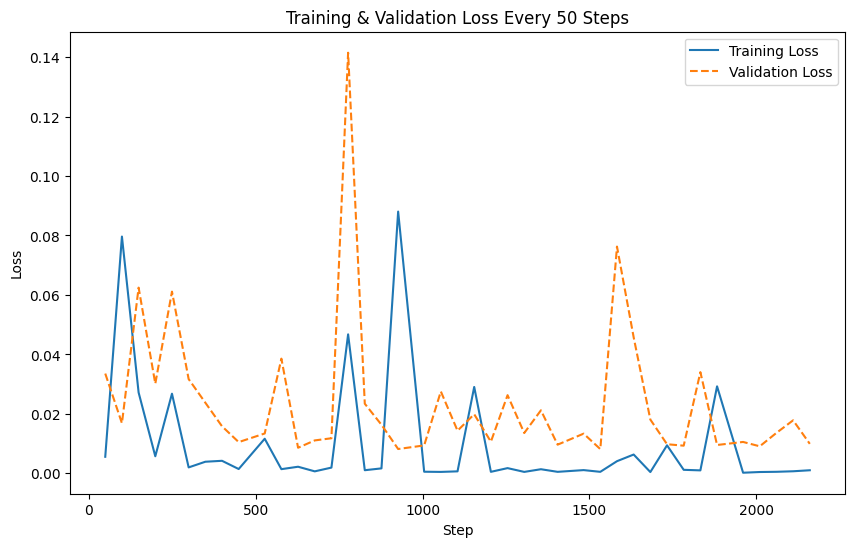

Iteration:  63%|██████▎   | 299/478 [04:03<02:01,  1.47it/s]

hi


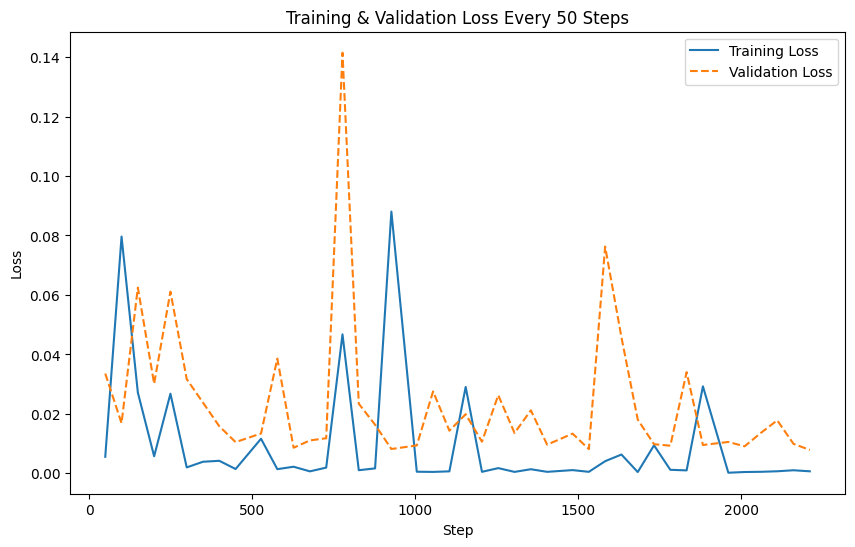

Iteration:  73%|███████▎  | 349/478 [04:43<01:26,  1.49it/s]

hi


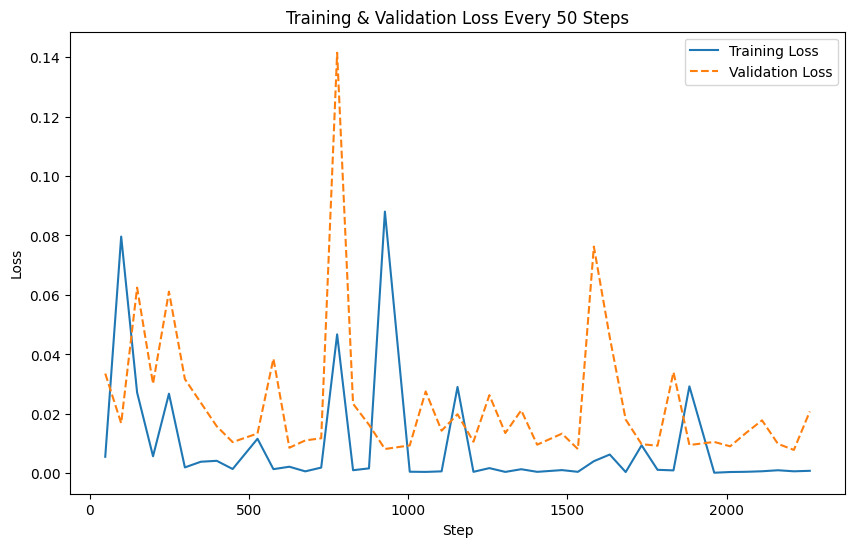

Iteration:  83%|████████▎ | 399/478 [05:23<00:52,  1.50it/s]

hi


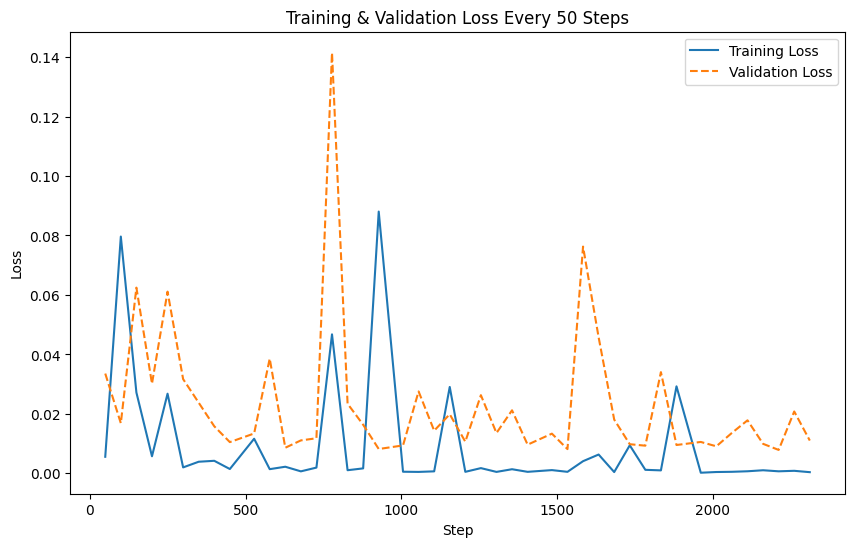

Iteration:  94%|█████████▍| 449/478 [06:03<00:17,  1.63it/s]

hi


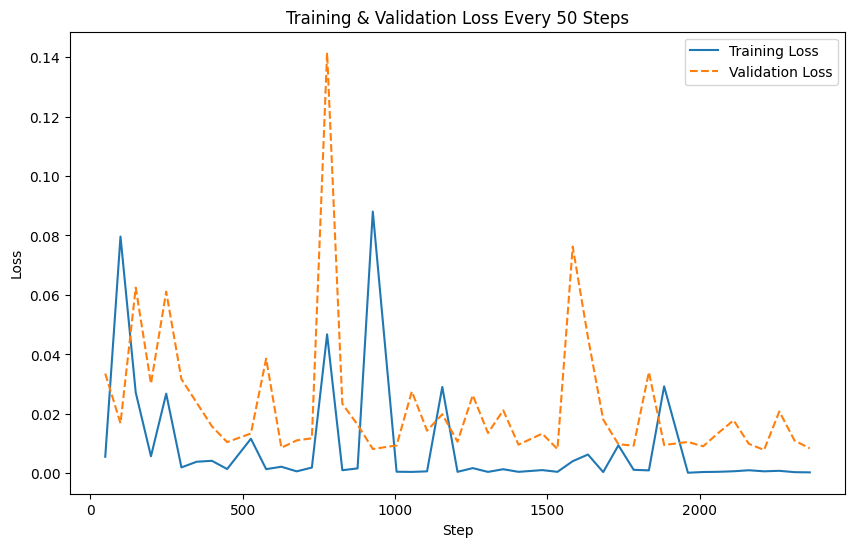

Iteration: 100%|██████████| 478/478 [06:27<00:00,  1.23it/s]


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: './finetuned_uncased2024-04-08 22:33:56.550230'

In [24]:
optimizer = AdamW(model_du1.parameters(), lr=learning_rate)

model_du1.train()

train_loss_values = []
valid_loss_values = []
steps = []
val_total_count = 100

for epoch in range(num_epochs):
    # Training phase 
    epoch_iterator = tqdm(train_loader, desc="Iteration")
    # calculate loss on an epoch level 

    for step, (tokens, labels) in enumerate(epoch_iterator):
        input_ids = tokens['input_ids'].to(model_du1.device)
        attention_mask = tokens['attention_mask'].to(model_du1.device)
        labels = labels.to(model_du1.device)

        optimizer.zero_grad()
        outputs = model_du1(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        if (step + 1) % 50 == 0: # exclude step 0
            print('hi')
            train_loss_values.append(loss.item())
            steps.append(step + epoch * len(epoch_iterator))

            # Validation
            model_du1.eval()
            total_val_loss = 0
            val_count = 0
            with torch.no_grad():
                for val_tokens, val_labels in valid_loader:
                    val_input_ids = val_tokens['input_ids'].to(model_du1.device)
                    val_attention_mask = val_tokens['attention_mask'].to(model_du1.device)
                    val_labels = val_labels.to(model_du1.device)
                    val_outputs = model_du1(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
                    val_loss = val_outputs.loss
                    total_val_loss += val_loss.item()
                    val_count += 1
                    if val_count > val_total_count:
                        break

            avg_val_loss = total_val_loss / val_total_count
            valid_loss_values.append(avg_val_loss)


            # Switch back to training mode
            model_du1.train()

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(steps, train_loss_values, label='Training Loss')
            plt.plot(steps, valid_loss_values, label='Validation Loss', linestyle='--')
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Training & Validation Loss Every 50 Steps')
            plt.legend()
            plt.show()



In [25]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_du1.save_pretrained(f'./finetuned_uncased_{timestamp}')

## calculate accuracy

In [30]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)



def calculate_accuracy(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad(): 
        for batch in tqdm(data_loader):
            input_ids = batch[0]['input_ids'].to(model.device)
            attention_mask = batch[0]['attention_mask'].to(model.device)
            labels = batch[1].to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

# Calculate test accuracy
test_accuracy = calculate_accuracy(model_du1, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

100%|██████████| 72/72 [00:35<00:00,  2.04it/s]

Test Accuracy: 98.90%


## custom input test

In [103]:
import torch.nn.functional as F


def eval_custom_sentence(model, test_sentence, true_label=0):
    model.eval()

    with torch.no_grad(): 
        tokenized_test_sentence = tokenizer(test_sentence, padding=True, truncation=True, return_tensors="pt").to(model.device)
        input_ids = tokenized_test_sentence['input_ids'].to(model.device)
        attention_mask = tokenized_test_sentence['attention_mask'].to(model.device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_label = torch.max(outputs.logits, dim=1)
        probabilities = F.softmax(outputs.logits, dim=1)
        
    return f"AI generated with confidence of {probabilities[0][0]*100:.2f}%" if predicted_label.item() == 0 else f"human written {probabilities[0][1]*100:.2f}%"

# Calculate test accuracy
test_sentence = "Dear Mrs. Principal, As a student maim i think, maybe your idea to make students have an average of B' s only would be a good idea for students to try harder to increase they're grades, but once you think about it twice maim some students have C 's because that is all they can give. Sometimes its not because they didn't study or because they were watching television but because sometimes we get so nervous that rush through the answers or even forget everything we have been studying super hard to succeed. Like I said before I believe not everyone can have an average of B 's but a C is already a passing grade. No one is perfect we all have a couple of mistakes sometimes. Either way if you do all B 's probably the whole school may not participate in any school activity. Now that is the why we shouldn't change it. We should change it though cause it might pressure the students to get higher grades to participate in a sport. The school may also have a higher percent of students passing and less students failing... Which would help the school get a higher score at the end of the year."
test_sentence2 = "In recent years, there has been a growing movement towards limiting car usage in various parts of the world, driven by concerns about environmental sustainability, public health, and urban livability. This essay aims to inform fellow citizens about the advantages of limiting car usage, drawing upon insights from several sources. One notable example of a community pioneering car-free living is Vauban, Germany. In this upscale suburb, residents have embraced a lifestyle that minimizes car ownership and usage. Streets are car-free, with limited parking spaces available at the edge of the development. As a result, the majority of families in Vauban do not own cars, and many have reported increased happiness and reduced stress levels as a result of this lifestyle change. Vauban serves as a model for the broader trend towards smart planning, which aims to separate suburban life from auto dependency."


print(f"predicted result: {eval_custom_sentence(model_du1, test_sentence)}")

tensor([[9.9991e-01, 9.4655e-05]], device='cuda:0')
0
predicted result: AI generated with confidence of 99.99%
